2024-01-19 11:21:27.247918: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 11:21:27.402293: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 11:21:27.402463: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 11:21:27.430847: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 11:21:27.487294: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-19 11:21:27.489431: I tensorflow/core/platform/cpu_feature_guard.cc:1

Training data shape:  (1624, 100, 100, 1)
Testing data shape:  (406, 100, 100, 1)
Training labels shape:  (1624, 8)
Testing labels shape:  (406, 8)


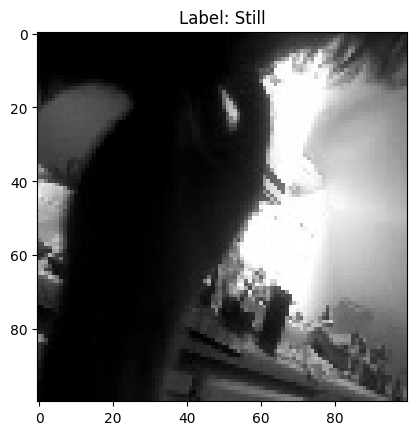

In [1]:
import h5py
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, Dropout, Convolution2D, GlobalAveragePooling2D
from keras.models import Sequential
import tensorflow as tf
import tensorflow.keras.applications.mobilenet
import os
from keras.layers import Dense , Dropout , Conv2D , MaxPooling2D, Flatten
from keras.layers import BatchNormalization
from keras.models import Sequential


label_dict = {
    0: "Subway",
    1: "Still",
    2: "Walking",
    3: "Run",
    4: "Bike",
    5: "Car",
    6: "Bus",
    7: "Train"
}


class DatasetLoader:
    def __init__(self, path):
        self.path = path
        self.x_train = None
        self.x_test = None
        self.y_train = None
        self.y_test = None

    def read_h5(self):
        with h5py.File(self.path, 'r') as f:
            X = np.array(f.get('inputs'))
            y = np.array(f.get('labels'))

        # One-hot encode the labels
        y = to_categorical(y, num_classes=len(label_dict))

        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=1)

        print("Training data shape: ", self.x_train.shape)
        print("Testing data shape: ", self.x_test.shape)
        print("Training labels shape: ", self.y_train.shape)
        print("Testing labels shape: ", self.y_test.shape)

        return self.x_train, self.x_test, self.y_train, self.y_test


    def get_data(self):
        return self.x_train, self.x_test, self.y_train, self.y_test


#instsate the class and get the data
dataset = DatasetLoader('video.h5')
dataset.read_h5()
x_train, x_test, y_train, y_test = dataset.get_data()


from matplotlib import pyplot as plt

def plot_image(image, label_vector):
    label_num = np.argmax(label_vector)  # Find the index of the max value
    label_name = label_dict[label_num]
    plt.imshow(image.squeeze(), cmap='gray')  # Assuming grayscale image
    plt.title(f"Label: {label_name}")
    plt.show()

# Plot a number of random images
for i in range(1):
    index = np.random.randint(0, len(x_train))
    plot_image(x_train[index], y_train[index])



In [30]:


def cnn():
    model = Sequential()

    model.add(Conv2D(32, kernel_size=(7, 7), padding='same', input_shape=(100, 100, 1)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, kernel_size=(3, 3), padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(len(label_dict), activation='softmax'))

    return model



model_cnn=cnn()
model_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),         # lr = learning_rate
    loss='categorical_crossentropy',   # Multi-class classification
    metrics=['accuracy']  
)

model_cnn.summary()

from keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with desired augmentations
data_gen = ImageDataGenerator(
    rotation_range=15,       # random rotation
    width_shift_range=0.1,   # random horizontal shifts
    height_shift_range=0.1,  # random vertical shifts
    shear_range=0.1,         # shear transformations
    zoom_range=0.1,          # random zoom
    horizontal_flip=True,    # horizontal flip
    fill_mode='nearest'
)

# Apply data augmentation to the training data
train_generator = data_gen.flow(x_train, y_train, batch_size=32)


history = model_cnn.fit(
    train_generator,
    epochs=100,
    steps_per_epoch=x_train.shape[0] // 32,  # Number of batches per epoch
    validation_data=(x_test, y_test)
)

model_cnn.save('model.h5')


import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 98, 98, 8)         80        
                                                                 
 conv2d_25 (Conv2D)          (None, 96, 96, 16)        1168      
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 48, 48, 16)        0         
 ng2D)                                                           
                                                                 
 dropout_18 (Dropout)        (None, 48, 48, 16)        0         
                                                                 
 conv2d_26 (Conv2D)          (None, 46, 46, 32)        4640      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                

2024-01-19 11:23:32.354856: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


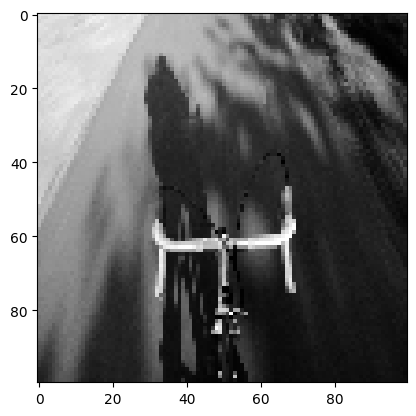

1/1 [==============================] - 0s 189ms/step
Predicted label: Bike


In [5]:
from keras.preprocessing import image
from matplotlib import pyplot as plt
import numpy as np
from keras.models import load_model

model_cnn = load_model('model.h5')

# Define the label dictionary (make sure it matches training)
label_dict = {
    0: "Subway",
    1: "Still",
    2: "Walking",
    3: "Run",
    4: "Bike",
    5: "Car",
    6: "Bus",
    7: "Train"
}

# Load and preprocess the image
img_path = 'bike.jpg'
img = image.load_img(img_path, target_size=(100, 100), color_mode='grayscale')
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)  # Add the batch dimension
img_tensor /= 255.  # Normalize the image

# Display the processed image
plt.imshow(img_tensor[0].squeeze(), cmap='gray')
plt.show()

# Predict the class of the image
prediction = model_cnn.predict(img_tensor)

# Get the index of the highest probability
predicted_class = np.argmax(prediction)

# Retrieve the label from the label dictionary
predicted_label = label_dict[predicted_class]
print(f"Predicted label: {predicted_label}")
